# Lambda Function

Construct and plot the lambda function, defined as:
$$
\Lambda(q,x) := \sum_{i=0}^{n} |l_i(x)| 
$$

In [1]:
# This is used for plots and numpy
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


In [2]:
def lagrange_basis(xi, i):
    def func(x):
        assert i<len(xi) and i>=0, 'Out of range: 0 < i < len(xi)'
        ret = 1;
        for xj in array([x for x in xi if x != xi[i]]):
            p = (x-xj)/(xi[i]-xj)
            ret *= p
        return ret
    return func

Test your implementation, plotting $l_i(x)$ for five equally spaced points.

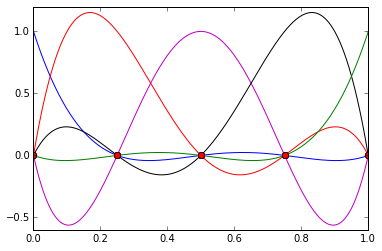

In [3]:
# Test space
xi = linspace(0,1,5)
x = linspace(0,1,1025)

for i in range(5):
    f = lagrange_basis(xi,i)
    plot(x, f(x))
    plot(xi, 0*xi, 'o')

In [4]:
def lambda_function(q):
    def to_eval(x):
        sum = 0.
        for i in range(len(q)):
            f = lagrange_basis(q, i)
            sum += abs(f(x))
        return sum
    return to_eval

In [5]:
from numpy.testing import *

assert_equal(lambda_function(linspace(0,1,3))(.25),1.25)
assert_almost_equal(lambda_function(linspace(0,1,5))(.3),1.2464,decimal=8)

Plot $\Lambda(q)(x)$ for equispaced nodes on the interval $[0,1]$ for 3, 5, and 7 equispaced nodes respectively. Comment the result.

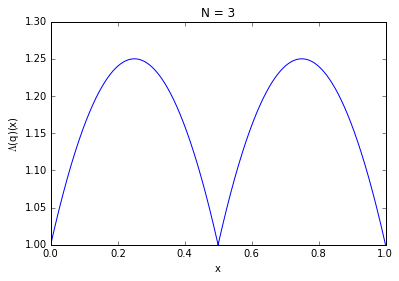

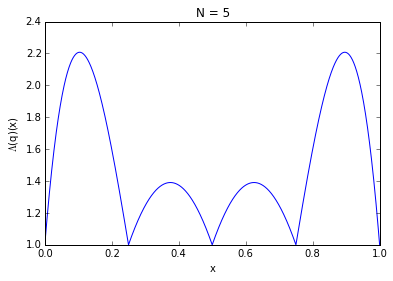

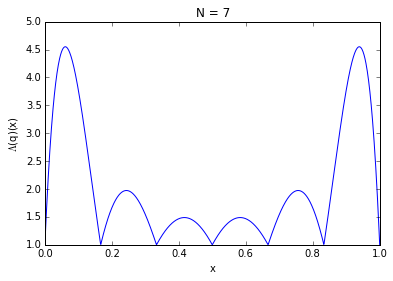

In [6]:
x = linspace(0., 1., 1025)
n_nodes = [3, 5, 7]

for N in n_nodes:
    q = linspace(0., 1., N)
    plot(x, lambda_function(q)(x))
    plt.xlabel('x') 
    plt.ylabel('$\Lambda$(q)(x)')
    plt.title('N = %d' % N)
    show()

YOUR ANSWER HERE

## Chebyshev Nodes

Chebyshev nodes are defined as:
$$
x_k = cos\left(\frac{2k-1}{2n} \pi \right), k = 1,\ldots,n.
$$
Write a function to evaluate then for a given $n$.


In [7]:
def chebyshev_nodes(n):
    points = array([cos( (2.* k - 1.) * pi / (2. * n) ) for k in range(1, n + 1)])
    return points

In [8]:
assert_almost_equal(chebyshev_nodes(5),[  9.51056516e-01, 5.87785252e-01,   6.12323400e-17,  -5.87785252e-01,
  -9.51056516e-01],decimal=8)
assert_almost_equal(chebyshev_nodes(7),[  9.74927912e-01,   7.81831482e-01,   4.33883739e-01,   6.12323400e-17,
  -4.33883739e-01,  -7.81831482e-01,  -9.74927912e-01],decimal=8)

Plot the location of chebyshev nodes on the unit circle, and on the orizontal axis.

 - plot the positive sector of a cirumference with center $0$ and radius $1$.
 - plot the location of chebicev points on the cirumference, suggested plot option is `'*'`.
 - plot projection lines from the circle center to chebyshev nodes projected on the circumference.
 - plot projection lines from chebyshev nodes projected on the circumference to chebyshev nodes on the horizontal axis.
 - plot chebyshev nodes, suggested plot option is `'o'`.
 - make sure the axis are such that the resulting plot is truly a circle...

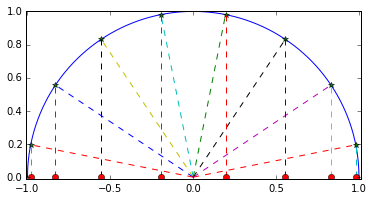

In [10]:
# semi - circumference function
circ = lambda x: sqrt(1. - x**2)

N = 8 #Number of chebyshev nodes
nodes = chebyshev_nodes(N)
x = linspace(-1, 1, 2049)
plt.figure(figsize=(6,6))
plot(x, circ(x))
plot(nodes, circ(nodes), '*')
for pt in nodes:
    plot((0., pt), (0., circ(pt)), '--')
    plot((pt, pt), (0., circ(pt)), '--')

plot(nodes, 0.*nodes, 'ro')
plt.xlim(-1.01, 1.01)
plt.ylim(-.01, 1.)
axes().set_aspect('equal')

Plot $\Lambda(q)(x)$ for chebyshev nodes on the interval $[x_0,x_n]$ for 3, 5, and 7 nodes respectively. Comment the result.

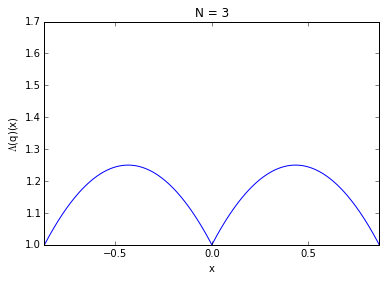

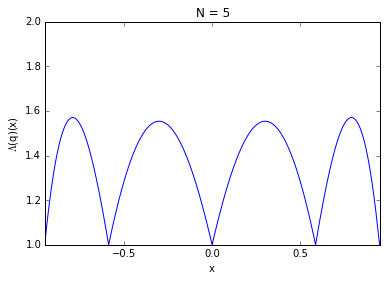

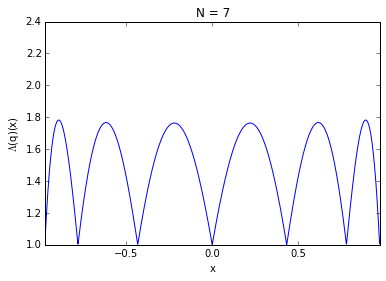

In [11]:
n_nodes = [3, 5, 7]

for N in n_nodes:
    q = chebyshev_nodes(N)
    plot(x, lambda_function(q)(x))
    plt.xlabel('x') 
    plt.ylabel('$\Lambda$(q)(x)')
    plt.title('N = %d' % N)
    plt.xlim(q.min(), q.max())
    show()

YOUR ANSWER HERE

Define a function `function_norm` that returns $||f(x)||\infty$ with $x\in[a,b]$ (default to $[0,1]$). To keep the implementation simple, evaluate the given function over $2^n+1$ points and return the maximum value. Any smarter and correct implementation is welcome. $n$ should be selectable at run time, and it should be by default equal to 20 (rhoughly a million points)

In [12]:
def function_norm(fun,a=0,b=1,n=20):
    x = linspace(a, b, 2**n + 1)
    vmax = 0.;
    for p in x:
        if vmax < abs(fun(p)):
            vmax = abs(fun(p))
    return vmax

In [16]:
assert_almost_equal(function_norm(lambda_function(linspace(0,1,7)),0,1,10),4.54922445348, decimal=5)
assert_almost_equal(function_norm(lambda_function(linspace(0,1,5)),0,1,10),2.20780651848, decimal=5)

xi = chebyshev_nodes(7)
assert_almost_equal(function_norm(lambda_function(xi),xi[0],xi[-1]),1.78252988655, decimal=5)

xi = chebyshev_nodes(5)
assert_almost_equal(function_norm(lambda_function(xi),xi[0],xi[-1]),1.57016748842, decimal=5)

Evaluate the $||\Lambda(q)||_{\infty}$ for degree from 1 to 7, for equispaced points, and for chebyshev nodes. Store the corresponding values in two different arrays `norm_l_eq`, and `norm_l_ch`.

In [13]:
norm_l_eq = array([ function_norm( lambda_function(linspace(0, 1, i)), 0, 1, 12) for i in arange(1, 8)])
norm_l_ch = array([ function_norm( lambda_function(chebyshev_nodes(i)), chebyshev_nodes(i).min(), chebyshev_nodes(i).max(), 12) for i in arange(1, 8)])

In [14]:
assert_almost_equal(norm_l_eq,[1.,1.,1.25,1.63113031,2.2078244,3.10630116,4.54934179], decimal=5)
assert_almost_equal(norm_l_ch,[1.,1.,1.25,1.42987272,1.57016749,1.68514046,1.78252989], decimal=5)

Plot the $||\Lambda(q,x)||_{\infty}$ for degree from 1 to 7, for equispaced points, and for chebyshev nodes.

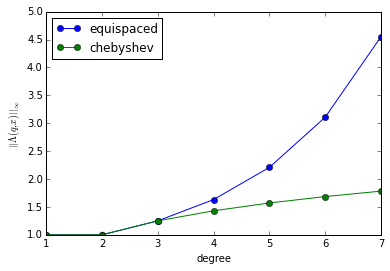

In [35]:
degree = arange(1,8)

plot(degree, norm_l_eq, '-o', label = 'equispaced')
plot(degree, norm_l_ch, '-o', label = 'chebyshev')
plt.xlabel('degree')
plt.ylabel('$|| \Lambda (q, x) ||_\infty$')
plt.legend(bbox_to_anchor=(.365, 1.))

# Bernstein Basis
Write a function that returns the ith Bernstein Basis of order $n$, using the standard definition: 
$$
B_{i,n}(t) = \binom{n}{i} t^i(1-t)^{n-i}
$$

In [ ]:
from scipy.special import binom as binomial
def bernstein_polynomial(n,i):
    def pol(x):
        return( binomial(n, i) * x**i * (1. - x)**(n - i) )
    return pol        

In [ ]:
# Use this cell to test the plot of your implementation
t = linspace(0,1)

for n in range(2,6):
    for i in range(0,n+1):
        b = bernstein_polynomial(n,i)
        plot(t,b(t))
    show()


In [ ]:
expected = [[0.48999999999999994, 0.42, 0.09], [0.3429999999999999, 0.4409999999999999, 0.189, 0.026999999999999996], [0.24009999999999995, 0.4115999999999999, 0.2646, 0.07559999999999999, 0.0081], [0.16806999999999994, 0.3601499999999999, 0.3086999999999999, 0.13229999999999997, 0.028349999999999993, 0.0024299999999999994]]

for n in range(2,3):
    for i in range(0,n+1):
        b = bernstein_polynomial(n,i)
        assert_almost_equal(b(.3),expected[n-2][i],decimal=8)

Implement the recursive definition of the bernstein polynomial:
$$
B_{k,n}(t) = (1-t)\cdot B_{k,n-1}(t)+t\cdot B_{k-1,n-1}(t)
$$

 - if $k < 0\ \mathrm{or}\ i > n$ then $B_{k,n} = 0$. 
 - if $k = 0\ \mathrm{and}\ n =0$ then $B_{k,n} = 1$. 

In [ ]:
def bernstein_recursive(n,k):
    def b_r(x):
        if(k < 0 or i > n):
            return 0
        elif(k == 0 and n == 0):
            return 1
        else:
            b1 = bernstein_recursive(n - 1, k)
            b2 = bernstein_recursive(n - 1, k - 1)
            return( (1. - x) * b1(x) + x * b2(x))
    return b_r        

In [ ]:
expected = [[0.48999999999999994, 0.42, 0.09], [0.3429999999999999, 0.4409999999999999, 0.189, 0.026999999999999996], [0.24009999999999995, 0.4115999999999999, 0.2646, 0.07559999999999999, 0.0081], [0.16806999999999994, 0.3601499999999999, 0.3086999999999999, 0.13229999999999997, 0.028349999999999993, 0.0024299999999999994]]

for n in range(2,3):
    for i in range(0,n+1):
        b = bernstein_recursive(n,i)
        assert_almost_equal(b(.3),expected[n-2][i],decimal=8)

Implement power basis formula:
$$
B_{k,n}(t) = \sum_{i=k}^n(-1)^{i-k}\binom{n}{i}\binom{i}{k}t^i
$$

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
expected = [[0.48999999999999994, 0.42, 0.09], [0.3429999999999999, 0.4409999999999999, 0.189, 0.026999999999999996], [0.24009999999999995, 0.4115999999999999, 0.2646, 0.07559999999999999, 0.0081], [0.16806999999999994, 0.3601499999999999, 0.3086999999999999, 0.13229999999999997, 0.028349999999999993, 0.0024299999999999994]]

for n in range(2,3):
    for i in range(0,n+1):
        b = bernstein_power_basis(n,i)
        assert_almost_equal(b(.3),expected[n-2][i],decimal=8)

Plot all basis obtained through the "definition" implementation and through the "power basis" implementation for n=20,40,80,100. Give an explanation for what you observe.

In [ ]:
alln = [20,40,80,100]

x = linspace(0,1)

def plot_all(k):
    # YOUR CODE HERE
    raise NotImplementedError()
    
for n in alln:
    plot_all(n)

YOUR ANSWER HERE

Given the basis functions above, construct the Bernstein approximation of a continuous function, defined as:
$$
B_n(f)(t) := \sum_{i=0}^{n} B_{i,n} (t) * f(i/n) 
$$

In [ ]:
def bernstein_interpolation(n,f):
    # YOUR CODE HERE
    raise NotImplementedError()

In [ ]:
func = lambda t : sin(2*pi*t)
bi = bernstein_interpolation(3,func)
expected = [  0.00000000e+00,1.92450090e-01,-1.92450090e-01,-2.44929360e-16]
assert_almost_equal(bi(linspace(0,1,4)),expected,decimal=8)
bi = bernstein_interpolation(15,func)
expected = [  0.00000000e+00,6.50601790e-01,-6.50601790e-01,-2.44929360e-16]
assert_almost_equal(bi(linspace(0,1,4)),expected,decimal=8)

Test your implementation, plotting the bernstein interpolation of $\sin(2\pi x)$ for different degrees:

In [ ]:
# Use this cell to test the plot of your implementation

func = lambda t : sin(2*pi*t)

t = linspace(0,1)
plot(t, func(t))

for n in range(10,20)+[60]+[70]+[80]:

    bi = bernstein_interpolation(n,func)
    plot(t, bi(t))

Given tolerance `tol` for the the function `func`, find the maximum order $n$ that satisfies $||f(x)-B_n(f)(x)||_\infty <\mathtt{tol}$. Use the `function_norm` previously implemented.

In [ ]:
def find_order_given_tolerance(func,tol):
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
func = lambda t : sin(2*pi*t)
assert_equal(find_order_given_tolerance(func,.05),77)

h = lambda x: abs(x-.5)
assert_equal(find_order_given_tolerance(h,.05),64)

g = lambda x: 1/(1+(10*x-5)**2)
assert_equal(find_order_given_tolerance(g,.1),187)